In [21]:
import pandas as pd
import networkx as nx
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [22]:
NC_backbone = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network_nuanced_sentiment.graphml")

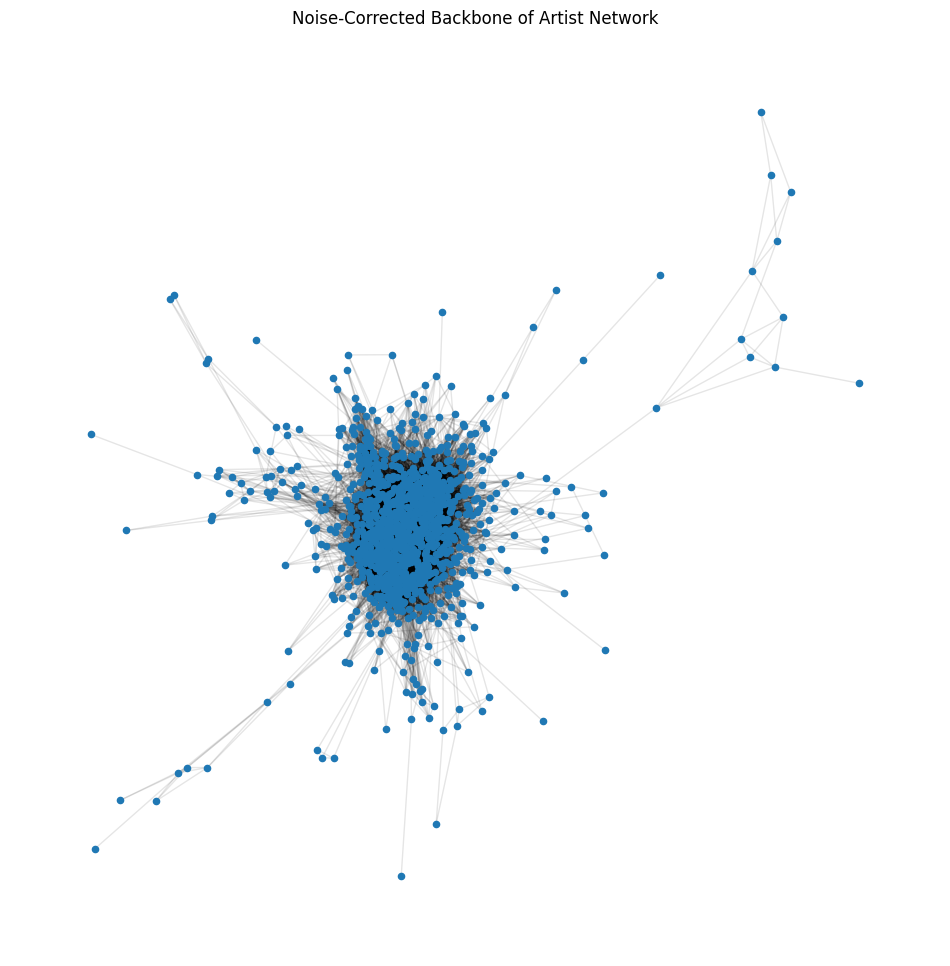

In [23]:
# plot backbone

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(NC_backbone, k=0.1)  # positions
nx.draw_networkx_nodes(NC_backbone, pos, node_size=20)
nx.draw_networkx_edges(NC_backbone, pos, alpha=0.1)
plt.title("Noise-Corrected Backbone of Artist Network")
plt.axis('off')
plt.show()

In [24]:
# remove all nodes with length of lyrics less than 50
count = 0

for node in list(NC_backbone.nodes):
    text = NC_backbone.nodes[node].get('lyrics','')
    if len(text) < 50:
        NC_backbone.remove_node(node)
        count += 1

print(f"Removed {count} nodes with lyrics length less than 50.")

Removed 21 nodes with lyrics length less than 50.


In [25]:
# find all cliques in the backbone
cliques = list(nx.find_cliques(NC_backbone))
print(f"Number of cliques in the backbone: {len(cliques)}")

# print the largest clique
largest_clique = max(cliques, key=len)
print(f"Largest clique size: {len(largest_clique)}")
print(f"Largest clique members: {largest_clique}")

# analyze clique size distribution
clique_sizes = [len(clique) for clique in cliques]
size_counts = pd.Series(clique_sizes).value_counts().sort_index()
print("Clique size distribution:")
print(size_counts)

Number of cliques in the backbone: 16577
Largest clique size: 9
Largest clique members: ['Carrie_Underwood', 'Blake_Shelton', 'Thompson_Square', 'Cole_Swindell', 'Jason_Aldean', 'Randy_Houser', 'Little_Big_Town', 'Jon_Pardi', 'Joe_Nichols']
Clique size distribution:
1       1
2     317
3    3542
4    6110
5    3958
6    1816
7     666
8     157
9      10
Name: count, dtype: int64


In [26]:
# plot cliques on backbone
"""
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(NC_backbone, k=0.1)  # positions
nx.draw_networkx_nodes(NC_backbone, pos, node_size=20)
nx.draw_networkx_edges(NC_backbone, pos, alpha=0.1)
for clique in cliques:
    if len(clique) >= 5:  # highlight cliques of size 5 or greater
        nx.draw_networkx_nodes(NC_backbone, pos, nodelist=clique, node_color='r', node_size=50)
plt.title("Cliques of Size 5 or Greater in Noise-Corrected Backbone")
plt.axis('off')
plt.show()
"""

'\nplt.figure(figsize=(12, 12))\npos = nx.spring_layout(NC_backbone, k=0.1)  # positions\nnx.draw_networkx_nodes(NC_backbone, pos, node_size=20)\nnx.draw_networkx_edges(NC_backbone, pos, alpha=0.1)\nfor clique in cliques:\n    if len(clique) >= 5:  # highlight cliques of size 5 or greater\n        nx.draw_networkx_nodes(NC_backbone, pos, nodelist=clique, node_color=\'r\', node_size=50)\nplt.title("Cliques of Size 5 or Greater in Noise-Corrected Backbone")\nplt.axis(\'off\')\nplt.show()\n'

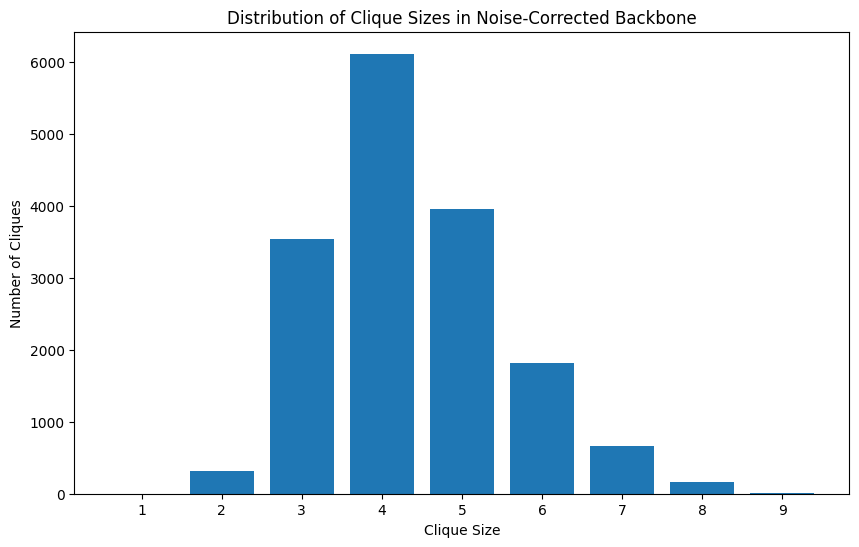

In [27]:
# plot the distribution of clique sizes
plt.figure(figsize=(10, 6))
plt.bar(size_counts.index, size_counts.values)
plt.xlabel('Clique Size')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Clique Sizes in Noise-Corrected Backbone')
plt.xticks(size_counts.index)
plt.show()

In [ ]:
# keep all cliques larger than size 5
filtered_cliques = [clique for clique in cliques if len(clique) >= 5]
print(f"Number of cliques of size 5 or greater: {len(filtered_cliques)}")


Number of cliques of size 5 or greater: 6607


In [29]:
# Averge weight of edges in cliques of size all sizes
for size in size_counts.index:
    clique_size_n = [clique for clique in cliques if len(clique) == size]
    edge_weights = []
    for clique in clique_size_n:
        edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
        for edge in edges:
            if NC_backbone.has_edge(*edge):
                edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    print(f"Average weight of edges in cliques of size {size}: {average_weight}")
  


Average weight of edges in cliques of size 1: nan
Average weight of edges in cliques of size 2: 1.2586750788643533
Average weight of edges in cliques of size 3: 1.966591379634858
Average weight of edges in cliques of size 4: 2.5719039825422803
Average weight of edges in cliques of size 5: 3.124532592218292
Average weight of edges in cliques of size 6: 3.4140602055800295
Average weight of edges in cliques of size 7: 3.345917345917346
Average weight of edges in cliques of size 8: 3.1310282074613283
Average weight of edges in cliques of size 9: 1.7361111111111112


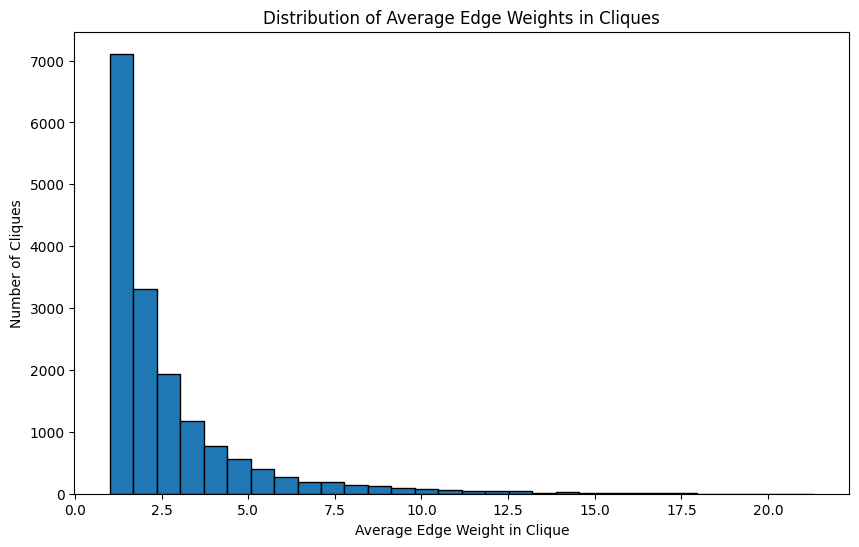

In [30]:
# Distribution of averge weights of edges in cliques
average_weights = []
for clique in cliques:
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    average_weights.append(average_weight)

plt.figure(figsize=(10, 6))
plt.hist(average_weights, bins=30, edgecolor='black')
plt.xlabel('Average Edge Weight in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Average Edge Weights in Cliques')
plt.show()

In [31]:
# Filter out cliques with average edge weight below a threshold
threshold = 15  # example threshold
strong_cliques = []
for clique in cliques:
    if len(clique) < 5:
        continue  # skip cliques with less than 2 nodes
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    if average_weight >= threshold:
        strong_cliques.append(clique)

print(f"Number of cliques with average edge weight >= {threshold}: {len(strong_cliques)}")


Number of cliques with average edge weight >= 15: 18


In [32]:
# Print strong cliques
for clique in strong_cliques:
    print(clique)
    print(f"Clique size: {len(clique)}")
    

['French_Montana', 'JAY_Z', 'Future', 'Drake', 'Childish_Gambino']
Clique size: 5
['The_Weeknd', 'Sia', 'Ariana_Grande', 'Disclosure', 'Drake']
Clique size: 5
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Juicy_J', 'Chris_Brown', 'Wiz_Khalifa']
Clique size: 6
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Juicy_J', 'Childish_Gambino']
Clique size: 5
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Kendrick_Lamar', 'Chris_Brown', 'Wiz_Khalifa']
Clique size: 6
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Kendrick_Lamar', 'Young_Thug', 'Chance_The_Rapper']
Clique size: 6
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Kendrick_Lamar', 'Young_Thug', 'Childish_Gambino']
Clique size: 6
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Meek_Mill', 'Wiz_Khalifa']
Clique size: 5
['The_Weeknd', 'Drake', 'Kid_Ink', 'Chris_Brown', 'Wiz_Khalifa', 'Kendrick_Lamar']
Clique size: 6
['The_Weeknd', 'Drake', 'Kid_Ink', 'Young_Thug', 'Kendrick_Lamar']
Clique size: 5
['The_Weeknd', 'Drake', 'Miguel', 'Kendrick_Lamar', 'Chris_Brown']
Clique size

In [33]:
# top 5 strong cliques by average edge weight
clique_weights = []
for clique in strong_cliques:
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if NC_backbone.has_edge(*edge):
            edge_weights.append(NC_backbone[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    clique_weights.append((clique, average_weight))
    clique_weights.sort(key=lambda x: x[1], reverse=True)

print("Top 5 strong cliques by average edge weight:")
for clique, weight in clique_weights[:5]:
    print(clique)
    print(f"Average edge weight: {weight}")

Top 5 strong cliques by average edge weight:
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Kendrick_Lamar', 'Chris_Brown', 'Wiz_Khalifa']
Average edge weight: 20.4
['The_Weeknd', 'Drake', 'Miguel', 'Kendrick_Lamar', 'Chris_Brown']
Average edge weight: 19.1
['The_Weeknd', 'Big_Sean', 'Wiz_Khalifa', 'Rae_Sremmurd', 'Kendrick_Lamar']
Average edge weight: 17.9
['The_Weeknd', 'Drake', 'Rae_Sremmurd', 'Kendrick_Lamar', 'Young_Thug', 'Childish_Gambino']
Average edge weight: 17.866666666666667
['The_Weeknd', 'Drake', 'Kid_Ink', 'Chris_Brown', 'Wiz_Khalifa', 'Kendrick_Lamar']
Average edge weight: 17.8


In [35]:
# std deviation in sentiment scores within cliques
mean_sentiments_cliques = []
std_dev_sentiments_cliques = []

for clique in filtered_cliques:
    sentiment_scores = []
    for node in clique:
        # get sentiment_compound attribute
        sentiment_scores.append(NC_backbone.nodes[node].get('sentiment_compound'))
    mean = np.mean(sentiment_scores)
    std = np.std(sentiment_scores)
    print(f"Clique size: {len(clique)}, Mean: {mean}, Standard deviation: {std}")
    # append clique mean and std to lists
    mean_sentiments_cliques.append(mean)
    std_dev_sentiments_cliques.append(std)



Clique size: 5, Mean: -0.041313551834105434, Standard deviation: 0.05209259554019159
Clique size: 5, Mean: 0.0037782524033207984, Standard deviation: 0.059743324212535386
Clique size: 5, Mean: -0.042040129754410495, Standard deviation: 0.05194845239306353
Clique size: 5, Mean: -0.039110629877714576, Standard deviation: 0.05209545489255005
Clique size: 5, Mean: 0.08345460249431573, Standard deviation: 0.03303154151186762
Clique size: 5, Mean: 0.0741278221996856, Standard deviation: 0.04342999349172215
Clique size: 5, Mean: 0.06278862937807189, Standard deviation: 0.04800300440147844
Clique size: 6, Mean: 0.03668174224515001, Standard deviation: 0.0605757649764339
Clique size: 5, Mean: 0.0319689915967303, Standard deviation: 0.07941881369116839
Clique size: 6, Mean: 0.03942864532602292, Standard deviation: 0.058840877976011605
Clique size: 5, Mean: 0.06479249071613716, Standard deviation: 0.0508441509615629
Clique size: 5, Mean: 0.06909171109673876, Standard deviation: 0.0480491906912100

In [41]:
# Top 5 cliques by sentiment score mean
top_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in x]), reverse=True)[:5]
print("Top 5 cliques by sentiment score mean:")
for clique in top_5_mean_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)

# bottom 5 cliques by sentiment score standard deviation
bottom_5_std_cliques = sorted(filtered_cliques, key=lambda x: np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in x]))[:5]
print("Bottom 5 cliques by sentiment score standard deviation:")
for clique in bottom_5_std_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)

Top 5 cliques by sentiment score mean:
Clique size: 5, Mean sentiment: 0.22909874500434668, Standard deviation: 0.08613894453839989
['Donnie_McClurkin', 'Mary_Mary', 'Chance_The_Rapper', 'Fred_Hammond', 'Israel_Houghton']
Clique size: 5, Mean sentiment: 0.2232401555328969, Standard deviation: 0.09131321631087926
['Donnie_McClurkin', 'Mary_Mary', 'Chance_The_Rapper', 'Fred_Hammond', 'Kirk_Franklin']
Clique size: 5, Mean sentiment: 0.17479514351521092, Standard deviation: 0.09412510132019919
['The_Band', 'Journey', 'John_Mellencamp', 'Otis_Redding', 'Bill_Withers']
Clique size: 5, Mean sentiment: 0.17433081570351622, Standard deviation: 0.0924709814586301
['Chuck_Berry', 'Bryan_Adams', 'Otis_Redding', 'Roy_Orbison', 'The_Doobie_Brothers']
Clique size: 5, Mean sentiment: 0.1657867911004195, Standard deviation: 0.10074532539236751
['Bill_Withers', 'Journey', 'Otis_Redding', 'The_Cranberries', 'John_Mellencamp']
Bottom 5 cliques by sentiment score standard deviation:
Clique size: 5, Mean se

In [37]:
# bottom 5 cliques by sentiment score mean
bottom_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in x]))[:5]
print("Bottom 5 cliques by sentiment score mean:")
for clique in bottom_5_mean_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    print("\n")

# top 5 cliques by sentiment score standard deviation
top_5_std_cliques = sorted(filtered_cliques, key=lambda x: np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in x]), reverse=True)[:5]
print("Top 5 cliques by sentiment score standard deviation:")
for clique in top_5_std_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    print("\n")

Bottom 5 cliques by sentiment score mean:
Clique size: 6, Mean sentiment: -0.0805383351016631, Standard deviation: 0.07367463718783666
['Kendrick_Lamar', 'XXXTENTACION', 'PnB_Rock', 'Kodak_Black', 'Kevin_Gates', 'A_Boogie_Wit_da_Hoodie']


Clique size: 7, Mean sentiment: -0.07708873812083719, Standard deviation: 0.059967859187797276
['50_Cent', 'DMX', 'Fat_Joe', 'Ludacris', 'Ying_Yang_Twins', 'Lil_Jon', 'Trick_Daddy']


Clique size: 5, Mean sentiment: -0.07538167417617667, Standard deviation: 0.013378660395338178
['Yo_Gotti', 'A_Boogie_Wit_da_Hoodie', 'Juicy_J', 'Kevin_Gates', 'PnB_Rock']


Clique size: 6, Mean sentiment: -0.07495952639605026, Standard deviation: 0.07630661453921476
['Kendrick_Lamar', 'XXXTENTACION', 'PnB_Rock', 'Kodak_Black', 'Kevin_Gates', 'Big_Sean']


Clique size: 5, Mean sentiment: -0.07093850335431341, Standard deviation: 0.08378376850909319
['Kendrick_Lamar', 'XXXTENTACION', 'Kid_Cudi', 'Big_Sean', 'Kevin_Gates']


Top 5 cliques by sentiment score standard devia

In [39]:
# top 20 biggest cliques
top_20_cliques = sorted(cliques, key=len, reverse=True)[:20]
# mean and std deviation of sentiment scores in top 20 cliques
for clique in top_20_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    print("\n")

Clique size: 9, Mean sentiment: 0.054466422757837245, Standard deviation: 0.026143991431929928
['Carrie_Underwood', 'Blake_Shelton', 'Thompson_Square', 'Cole_Swindell', 'Jason_Aldean', 'Randy_Houser', 'Little_Big_Town', 'Jon_Pardi', 'Joe_Nichols']


Clique size: 9, Mean sentiment: 0.06552110376300023, Standard deviation: 0.0533280871248231
['Joe_Nichols', 'Jason_Aldean', 'Blake_Shelton', 'Cole_Swindell', 'Randy_Travis', 'Little_Big_Town', 'Kenny_Chesney', 'Alan_Jackson', 'Trace_Adkins']


Clique size: 9, Mean sentiment: -0.02794421972622454, Standard deviation: 0.07344298751708267
['50_Cent', 'Twista', 'Sean_Paul', 'Three_6_Mafia', 'Trina', 'Trick_Daddy', 'Soulja_Boy', 'Fat_Joe', 'Lil_Jon']


Clique size: 9, Mean sentiment: -0.025258309389050472, Standard deviation: 0.06379593089880524
['50_Cent', 'Twista', 'Ludacris', 'Soulja_Boy', 'Three_6_Mafia', 'Trina', 'Trick_Daddy', 'Busta_Rhymes', 'Bubba_Sparxxx']


Clique size: 9, Mean sentiment: -0.035876022914311745, Standard deviation: 0.06

In [40]:
# top 20 cliques by lowest standard deviation in sentiment scores
top_10_lowest_std_cliques = sorted(filtered_cliques, key=lambda x: np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in x]))[:10]
print("Top 10 cliques by lowest standard deviation in sentiment scores:")
for clique in top_10_lowest_std_cliques:
    mean = np.mean([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([NC_backbone.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
    # print sentiment scores
    sentiment_scores = [NC_backbone.nodes[node].get('sentiment_compound') for node in clique]
    print(f"Sentiment scores: {sentiment_scores}")
    print("\n")

Top 10 cliques by lowest standard deviation in sentiment scores:
Clique size: 5, Mean sentiment: 0.024554365422099406, Standard deviation: 0.005280056943970268
['French_Montana', 'Lil_Uzi_Vert', 'J_Balvin', 'PARTYNEXTDOOR', 'Drake']
Sentiment scores: [0.0155043537414966, 0.030193152302243217, 0.02324171974522293, 0.029447689898198903, 0.02438491142333537]


Clique size: 5, Mean sentiment: 0.06899751279254906, Standard deviation: 0.0070539704377205565
['Flume', 'Timeflies', 'Kygo', 'Hailee_Steinfeld', 'Jonas_Blue']
Sentiment scores: [0.06267632978723404, 0.07280426540284361, 0.08115578947368421, 0.06427097625329817, 0.06408020304568529]


Clique size: 5, Mean sentiment: 0.08209455883722169, Standard deviation: 0.007370158647763885
['Toby_Keith', 'Alan_Jackson', 'Miranda_Lambert', 'Darius_Rucker', 'Luke_Bryan']
Sentiment scores: [0.07965193199381762, 0.09124173913043479, 0.08184938271604937, 0.08783807947019867, 0.06989166087560805]


Clique size: 5, Mean sentiment: 0.06970531489781222, 

### EMBEDDINGS

In [43]:
# load graphml file
NC_backbone = nx.read_graphml(r"/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network_with_embeddings.graphml")

In [44]:
import networkx as nx
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
G = NC_backbone

# Example: Get vector for a specific node
node_id = list(G.nodes())[0]

if 'lyric_vector' in G.nodes[node_id]:
    # 1. Get the string
    vector_str = G.nodes[node_id]['lyric_vector']
    
    # 2. Convert String -> List -> Numpy Array
    vector = np.array(json.loads(vector_str))
    
    print(f"Node: {node_id}")
    print(f"Vector Shape: {vector.shape}")
    
    # Now you can use it for cosine similarity immediately:
    # sim = cosine_similarity([vector], [other_vector])


Node: Missy_Elliott
Vector Shape: (384,)


In [47]:
# calculate the average cosine similarity between all pairs of nodes in clusters based on 'lyric_vector' attribute
from itertools import combinations

average_cosine_sims_of_cliques = []

for clique in filtered_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    if len(vectors) < 2:
        continue  # skip cliques with less than 2 vectors
    cosine_sims = []
    for vec1, vec2 in combinations(vectors, 2):
        sim = cosine_similarity([vec1], [vec2]) 
        cosine_sims.append(sim)
    average_cosine_sim = np.mean(cosine_sims)
    average_cosine_sims_of_cliques.append(average_cosine_sim)
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {average_cosine_sim}")



Clique size: 5, Average Cosine Similarity: 0.4482074474303487
Clique size: 5, Average Cosine Similarity: 0.47517918578484475
Clique size: 5, Average Cosine Similarity: 0.5116304556915083
Clique size: 5, Average Cosine Similarity: 0.49170932579230636
Clique size: 5, Average Cosine Similarity: 0.28338765437053587
Clique size: 5, Average Cosine Similarity: 0.2953305651593457
Clique size: 5, Average Cosine Similarity: 0.2833319630503334
Clique size: 6, Average Cosine Similarity: 0.2710293296091422
Clique size: 5, Average Cosine Similarity: 0.2965900730544077
Clique size: 6, Average Cosine Similarity: 0.2734050533827871
Clique size: 5, Average Cosine Similarity: 0.4162129367487554
Clique size: 5, Average Cosine Similarity: 0.44295237214576433
Clique size: 5, Average Cosine Similarity: 0.4152174716123107
Clique size: 5, Average Cosine Similarity: 0.43670221094851974
Clique size: 5, Average Cosine Similarity: 0.30666984616509424
Clique size: 5, Average Cosine Similarity: 0.3448905868091527
Cl

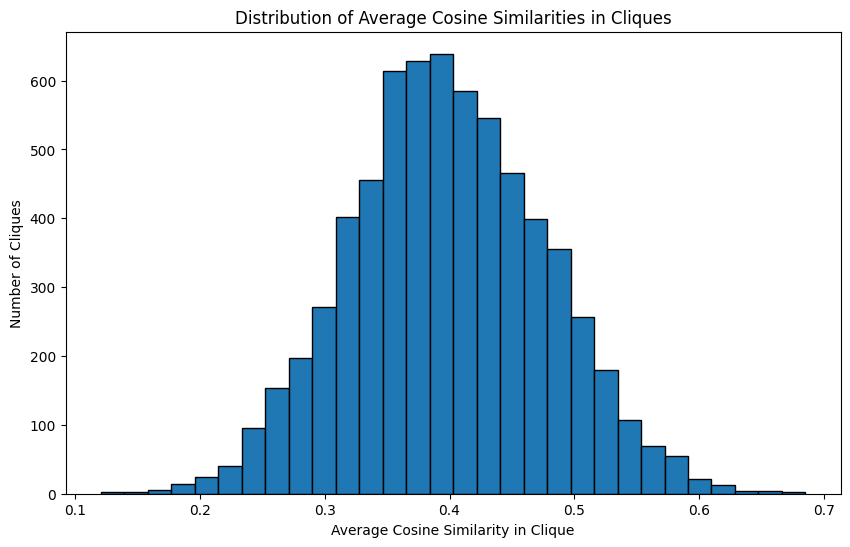

In [48]:
# plot the distributon of average cosine similarities

plt.figure(figsize=(10, 6))
plt.hist(average_cosine_sims_of_cliques, bins=30, edgecolor='black')
plt.xlabel('Average Cosine Similarity in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Average Cosine Similarities in Cliques')
plt.show()


In [49]:
# print average cosine similarity of top 20 biggest cliques
top_20_cliques = sorted(cliques, key=len, reverse=True)[:20]
for clique in top_20_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    if len(vectors) < 2:
        continue  # skip cliques with less than 2 vectors
    cosine_sims = []
    for vec1, vec2 in combinations(vectors, 2):
        sim = cosine_similarity([vec1], [vec2]) 
        cosine_sims.append(sim)
    average_cosine_sim = np.mean(cosine_sims)
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {average_cosine_sim}")


Clique size: 9, Average Cosine Similarity: 0.45964234584155594
Clique size: 9, Average Cosine Similarity: 0.363269246034971
Clique size: 9, Average Cosine Similarity: 0.5243475654245688
Clique size: 9, Average Cosine Similarity: 0.4902881265637194
Clique size: 9, Average Cosine Similarity: 0.4971582171033262
Clique size: 9, Average Cosine Similarity: 0.469547778859538
Clique size: 9, Average Cosine Similarity: 0.43592088821556835
Clique size: 9, Average Cosine Similarity: 0.4182076095803065
Clique size: 9, Average Cosine Similarity: 0.4025502761745052
Clique size: 9, Average Cosine Similarity: 0.38391731399600115
Clique size: 8, Average Cosine Similarity: 0.5213802244997973
Clique size: 8, Average Cosine Similarity: 0.491166904552521
Clique size: 8, Average Cosine Similarity: 0.5736692399683126
Clique size: 8, Average Cosine Similarity: 0.55413208907937
Clique size: 8, Average Cosine Similarity: 0.5419906222124095
Clique size: 8, Average Cosine Similarity: 0.5275260924434657
Clique siz

In [50]:
# print average similarity on strong cliques
for clique in strong_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    if len(vectors) < 2:
        continue  # skip cliques with less than 2 vectors
    cosine_sims = []
    for vec1, vec2 in combinations(vectors, 2):
        sim = cosine_similarity([vec1], [vec2]) 
        cosine_sims.append(sim)
    average_cosine_sim = np.mean(cosine_sims)
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {average_cosine_sim}")


Clique size: 5, Average Cosine Similarity: 0.49755452421056245
Clique size: 5, Average Cosine Similarity: 0.5085895983604688
Clique size: 6, Average Cosine Similarity: 0.4849709490396809
Clique size: 5, Average Cosine Similarity: 0.5035721269046871
Clique size: 6, Average Cosine Similarity: 0.5102307726294832
Clique size: 6, Average Cosine Similarity: 0.5196907314830962
Clique size: 6, Average Cosine Similarity: 0.5381733756865593
Clique size: 5, Average Cosine Similarity: 0.5349104862528675
Clique size: 6, Average Cosine Similarity: 0.5179108205830075
Clique size: 5, Average Cosine Similarity: 0.5679900445803385
Clique size: 5, Average Cosine Similarity: 0.557424257775361
Clique size: 5, Average Cosine Similarity: 0.5384635605375088
Clique size: 5, Average Cosine Similarity: 0.5389377028870926
Clique size: 5, Average Cosine Similarity: 0.5547273151768746
Clique size: 5, Average Cosine Similarity: 0.5202158229720938
Clique size: 5, Average Cosine Similarity: 0.4443333468930607
Clique s

In [51]:
# top 10 cliques by average cosine similarity
top_10_cosine_cliques = sorted(filtered_cliques, key=lambda clique: np.mean([
    cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
    for node1, node2 in combinations(clique, 2)]), reverse=True)[:10]

print("Top 10 cliques by average cosine similarity:")
for clique in top_10_cosine_cliques:
    mean = np.mean([cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
                       for node1, node2 in combinations(clique, 2)])
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {mean}")
    print(clique)
    print("\n")
    

Top 10 cliques by average cosine similarity:
Clique size: 5, Average Cosine Similarity: 0.6849303782806868
['Ozuna', 'Luis_Fonsi', 'J_Balvin', 'Maluma', 'Reik']


Clique size: 5, Average Cosine Similarity: 0.6678001029685126
['Noriel', 'Yandel', 'Maluma', 'Ozuna', 'J_Balvin']


Clique size: 5, Average Cosine Similarity: 0.6584612055605039
['Noriel', 'Yandel', 'Maluma', 'Pepe_Quintana', 'J_Balvin']


Clique size: 5, Average Cosine Similarity: 0.6545586005505684
['Tyga', 'Mike_Stud', 'Meek_Mill', 'Yo_Gotti', 'Big_Sean']


Clique size: 5, Average Cosine Similarity: 0.6518538816226755
['Mike_WiLL_Made-It', 'Fetty_Wap', 'Future', 'The_Game', 'Snoop_Dogg']


Clique size: 5, Average Cosine Similarity: 0.651811947268879
['Ozuna', 'Reik', 'Maluma', 'Farruko', 'Bad_Bunny']


Clique size: 5, Average Cosine Similarity: 0.6424340707137987
['The_Game', 'JAY_Z', 'Snoop_Dogg', 'Fetty_Wap', 'Future']


Clique size: 5, Average Cosine Similarity: 0.6409796255370793
['ScHoolboy_Q', 'Meek_Mill', 'Young_Thu

In [52]:
top_30_cosine_cliques = sorted(filtered_cliques, key=lambda clique: np.mean([
    cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
    for node1, node2 in combinations(clique, 2)]), reverse=True)[:30]

print("Top 30 cliques by average cosine similarity:")
for clique in top_30_cosine_cliques:
    mean = np.mean([cosine_similarity([np.array(json.loads(G.nodes[node1]['lyric_vector']))], 
                                      [np.array(json.loads(G.nodes[node2]['lyric_vector']))])[0][0]
                       for node1, node2 in combinations(clique, 2)])
    print(f"Clique size: {len(clique)}, Average Cosine Similarity: {mean}")
    print(clique)
    print("\n")

Top 30 cliques by average cosine similarity:
Clique size: 5, Average Cosine Similarity: 0.6849303782806868
['Ozuna', 'Luis_Fonsi', 'J_Balvin', 'Maluma', 'Reik']


Clique size: 5, Average Cosine Similarity: 0.6678001029685126
['Noriel', 'Yandel', 'Maluma', 'Ozuna', 'J_Balvin']


Clique size: 5, Average Cosine Similarity: 0.6584612055605039
['Noriel', 'Yandel', 'Maluma', 'Pepe_Quintana', 'J_Balvin']


Clique size: 5, Average Cosine Similarity: 0.6545586005505684
['Tyga', 'Mike_Stud', 'Meek_Mill', 'Yo_Gotti', 'Big_Sean']


Clique size: 5, Average Cosine Similarity: 0.6518538816226755
['Mike_WiLL_Made-It', 'Fetty_Wap', 'Future', 'The_Game', 'Snoop_Dogg']


Clique size: 5, Average Cosine Similarity: 0.651811947268879
['Ozuna', 'Reik', 'Maluma', 'Farruko', 'Bad_Bunny']


Clique size: 5, Average Cosine Similarity: 0.6424340707137987
['The_Game', 'JAY_Z', 'Snoop_Dogg', 'Fetty_Wap', 'Future']


Clique size: 5, Average Cosine Similarity: 0.6409796255370793
['ScHoolboy_Q', 'Meek_Mill', 'Young_Thu